In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import h5py
from sklearn.linear_model import Ridge, Lasso, LassoCV, LassoLarsCV, LinearRegression, BayesianRidge, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import time
# import statsmodels.api as sm
# from patsy import dmatrix

# Here we are importing the h5 file and create a dataframe.

In [2]:
file = h5py.File('Data_Fuchs_v_2.7_Wright_Pat_Narrow_Range_energy_limit_0.01_deviation_0.5_lambda_um_0.8_points_100000_seed_6991.h5','r')
file_dict = dict()
for i in file.keys():
    file_dict[i] = file[i][:]
file.close()
physics = pd.DataFrame(file_dict)

# Here we specify the input and output variables

In [3]:
outputs = ['Max_Proton_Energy_(MeV)', 'Total_Proton_Energy_(MeV)', 'Avg_Proton_Energy_(MeV)']

In [4]:
# this is to avoid copying a pasting
inputs = []
for i in physics.columns:
    if i in outputs:
        continue
    else:
        inputs.append(i)
inputs

['Intensity_(W_cm2)',
 'Pulse_Duration_(fs)',
 'Spot_Size_(FWHM um)',
 'Target_Thickness (um)']

##### For now, we will work with a dataframe that only has Max Proton Energy as the output variable and name it df1.

In [5]:
df1 = physics.copy()
df1 = df1.drop(columns=outputs[1:])
df1.columns

Index(['Intensity_(W_cm2)', 'Max_Proton_Energy_(MeV)', 'Pulse_Duration_(fs)',
       'Spot_Size_(FWHM um)', 'Target_Thickness (um)'],
      dtype='object')

##### The rows that contain negative Max Proton Energy will be dropped.

In [6]:
df1 = df1[df1[outputs[0]] > 0]

##### The train and split sets will also be created here for df1.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df1[[inputs[0], inputs[3]]], df1[outputs[0]], test_size=0.33, random_state=0)

# Scatter plot of the data to be modeled.

##### The colors in the following scatter plot are only to give the plot a 3d feel. The colors are not meant to indicate the value of a fourth variable.

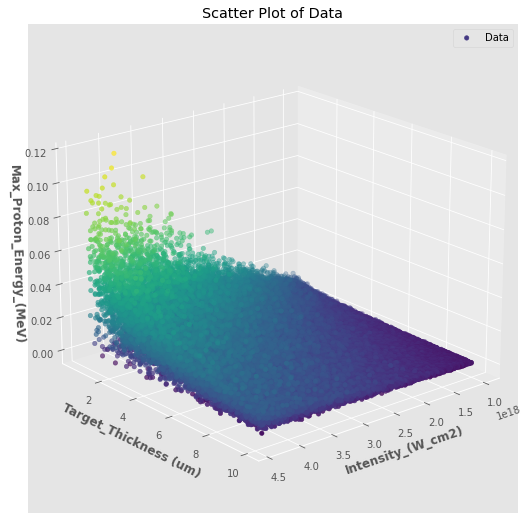

In [8]:
fig1 = plt.figure(figsize=(9, 9))
ax = fig1.add_subplot(projection='3d')
ax.scatter(X_train[inputs[0]],
           X_train[inputs[3]],
           y_train,
           c = np.sqrt(y_train),
           label = "Data")
ax.set_title('Scatter Plot of Data')
ax.set_xlabel(f'{inputs[0]}', fontweight ='bold')
ax.set_ylabel(f'{inputs[3]}', fontweight ='bold')
ax.set_zlabel(f'{outputs[0]}', fontweight ='bold')
ax.view_init(20, 50)
plt.legend(loc="upper right")
plt.show()

# Spline Model

##### First we create a model to predict the values of the X train set to see what the predictions look like

In [9]:
start_time = time.process_time()

In [10]:
spline_model = make_pipeline(SplineTransformer(n_knots=10, degree=3), Ridge(alpha=.001))

In [11]:
spline_model.fit(X_train, np.log(y_train))

Pipeline(steps=[('splinetransformer', SplineTransformer(n_knots=10)),
                ('ridge', Ridge(alpha=0.001))])

In [12]:
np.exp(spline_model.predict(X_train))

array([0.00243008, 0.0039228 , 0.00427884, ..., 0.0051798 , 0.0204372 ,
       0.0011865 ])

##### CPU time to run, train, and predict data

In [13]:
end_time = time.process_time()
print(f'The CPU time for this model to run is {end_time - start_time} seconds.')
del start_time
del end_time

The CPU time for this model to run is 0.29790199999999967 seconds.


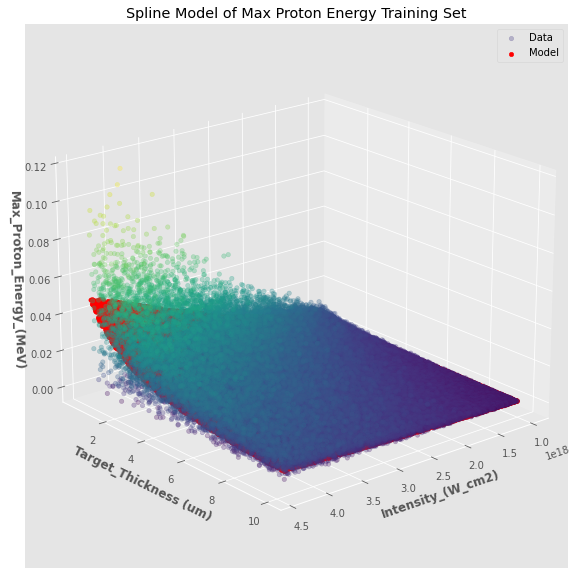

In [30]:
fig2 = plt.figure(figsize=(10, 10))
ax = fig2.add_subplot(projection='3d')
ax.scatter(X_train[inputs[0]],
           X_train[inputs[3]],
           y_train,
           alpha = .3,
           c = np.sqrt(y_train),
           label= 'Data')
ax.scatter(X_train[inputs[0]],
           X_train[inputs[3]],
           np.exp(spline_model.predict(X_train)),
           c = 'red',
           alpha= 1,
           label= 'Model')
ax.set_title('Spline Model of Max Proton Energy Training Set')
ax.set_xlabel(f'{inputs[0]}', fontweight ='bold')
ax.set_ylabel(f'{inputs[3]}', fontweight ='bold')
ax.set_zlabel(f'{outputs[0]}', fontweight ='bold')
ax.view_init(20, 50)
plt.legend(loc="upper right")
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[1].set_alpha(1)
plt.show()

##### An error dataframe will be created for the log transformed data model for the testing sets. This dataframe will also contain the predicted values of the log model, and it will contain the predicted values of the model converted back into its original non log format.

In [15]:
error_3d = X_test.copy()
error_3d['Predictions'] = np.exp(spline_model.predict(X_test))
error_3d['Relative Error'] = np.abs((y_test - error_3d['Predictions']) / y_test) * 100

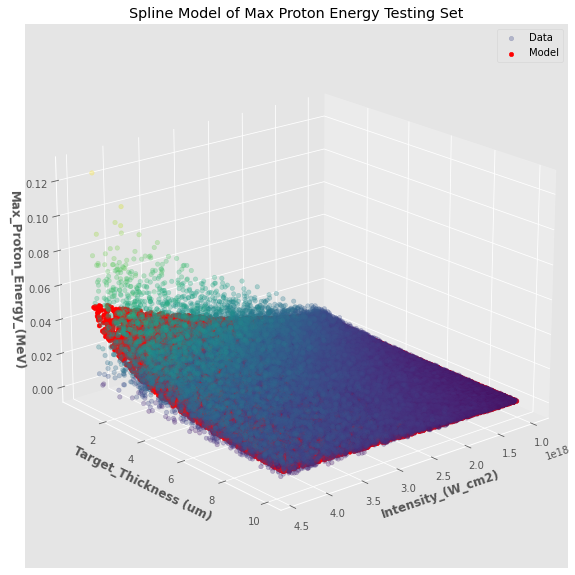

In [32]:
fig3 = plt.figure(figsize=(10, 10))
ax = fig3.add_subplot(projection='3d')
ax.scatter(X_test[inputs[0]],
           X_test[inputs[3]],
           y_test,
           c = np.sqrt(y_test),
           alpha = .3,
           label= 'Data')
ax.scatter(X_test[inputs[0]],
           X_test[inputs[3]],
           error_3d['Predictions'],
           c = 'red',
           alpha= 1,
           label= 'Model')
ax.set_title('Spline Model of Max Proton Energy Testing Set')
ax.set_xlabel(f'{inputs[0]}', fontweight ='bold')
ax.set_ylabel(f'{inputs[3]}', fontweight ='bold')
ax.set_zlabel(f'{outputs[0]}', fontweight ='bold')
ax.view_init(20, 50)
plt.legend(loc="upper right")
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[1].set_alpha(1)
plt.show()

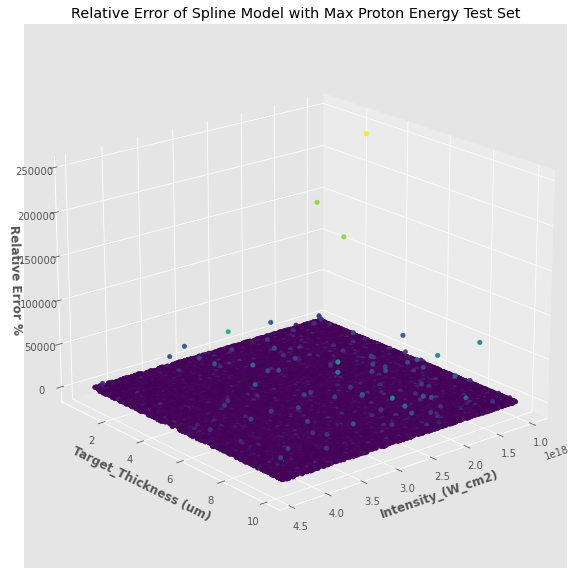

In [17]:
fig4 = plt.figure(figsize=(10, 10))
ax = fig4.add_subplot(projection='3d')
ax.scatter(X_test[inputs[0]],
           X_test[inputs[3]],
           error_3d['Relative Error'],
           alpha = 1,
           c = np.sqrt(error_3d['Relative Error']))
ax.set_title('Relative Error of Spline Model with Max Proton Energy Test Set')
ax.set_xlabel(f'{inputs[0]}', fontweight ='bold')
ax.set_ylabel(f'{inputs[3]}', fontweight ='bold')
ax.set_zlabel(f'Relative Error %', fontweight ='bold')
ax.view_init(20, 50)
plt.show()

In [18]:
mean_squared_error(y_test, error_3d['Predictions'])

2.014327712082517e-05

# Removing the mild and extreme outliers

In [19]:
error_3d_2 = error_3d.copy()
q1 = np.percentile(error_3d_2['Relative Error'], 25)
q3 = np.percentile(error_3d_2['Relative Error'], 75)
iqr = q3 - q1
error_3d_2 = error_3d_2[(error_3d_2['Relative Error'] >= q1 - 1.5 * iqr) & (error_3d_2['Relative Error'] <= q1 + 1.5 * iqr)]

In [20]:
error_3d_2

,Intensity_(W_cm2),Target_Thickness (um),Predictions,Relative Error
98026,1.572052e+18,0.974499,0.006723,10.536551
87979,1.574354e+18,3.173685,0.003088,52.785567
52659,2.028324e+18,4.786844,0.003185,55.194758
66276,1.188306e+18,4.347711,0.001390,54.042806
29048,1.069501e+18,1.908392,0.002377,32.650326
...,...,...,...,...
58566,4.390050e+18,6.613604,0.007813,40.153450
50394,1.215052e+18,1.100056,0.004105,41.836411
65755,2.263965e+18,2.253248,0.007786,17.213096
6149,2.050592e+18,4.291067,0.003651,27.923021


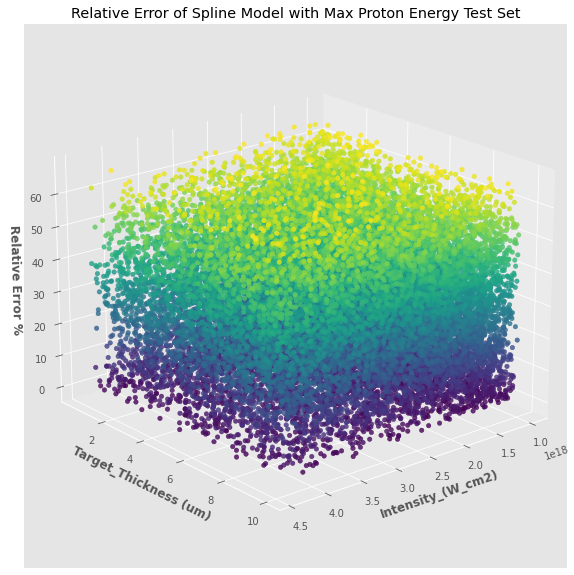

In [21]:
fig5 = plt.figure(figsize=(10, 10))
ax = fig5.add_subplot(projection='3d')
ax.scatter(error_3d_2[inputs[0]],
           error_3d_2[inputs[3]],
           error_3d_2['Relative Error'],
           alpha = .8,
           c = error_3d_2['Relative Error'])
ax.set_title('Relative Error of Spline Model with Max Proton Energy Test Set')
ax.set_xlabel(f'{inputs[0]}', fontweight ='bold')
ax.set_ylabel(f'{inputs[3]}', fontweight ='bold')
ax.set_zlabel(f'Relative Error %', fontweight ='bold')
ax.view_init(20, 50)
plt.show()